This notebook section provides visualizations and analysis of the autoencoder model's performance and outputs. The following cells include:

- Plotting a histogram of reconstruction errors to assess model accuracy.
- Displaying training and validation loss curves to monitor learning progress.
- Visualizing the learned latent space embeddings with a scatter plot.
- Instructions and code for exporting the trained PyTorch model to ONNX format and visualizing its architecture using Netron.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from pathlib import Path

RUN_ID = "20250513_220708"

# Common project paths
from PyISV import (
    MODELS_DIR as models_dir, DATA_DIR as data_dir, OUTPUTS_DIR as outputs_dir,
    NORMS_DIR as norms_dir, STATS_DIR as stats_dir
)

/leonardo_scratch/large/userexternal/fraseraf/PyISV/outputs


Inputs shape: (14400, 1, 340)
Targets shape: (14400, 1, 340)


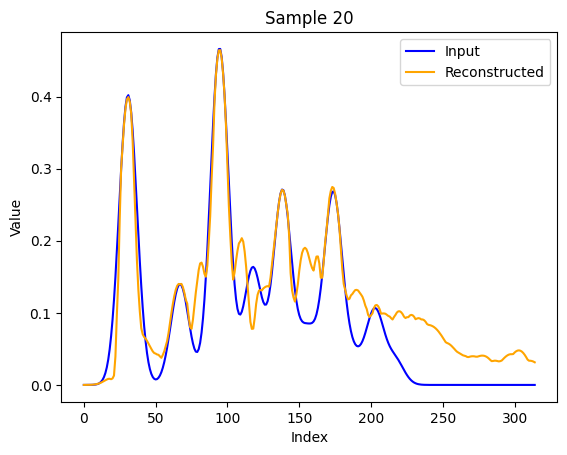

In [11]:
def plot_reconstructed_vs_input(inputs, outputs, sample_idx):

    fig, ax = plt.subplots()
    ax.plot(inputs[sample_idx, 0, 25:], label="Input", color="blue")
    ax.plot(outputs[sample_idx, 0, 25:], label="Reconstructed", color="orange")
    ax.legend()
    ax.set_title(f"Sample {sample_idx}")
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")

inputs = np.load(f"{outputs_dir}/evaluation/{RUN_ID}_val_targets.npy")
outputs = np.load(f"{outputs_dir}/evaluation/{RUN_ID}_reconstructed_outputs.npy")

print(f"Inputs shape: {inputs.shape}")
print(f"Targets shape: {outputs.shape}")

plot_reconstructed_vs_input(inputs, outputs, 20)


[0.00816687]


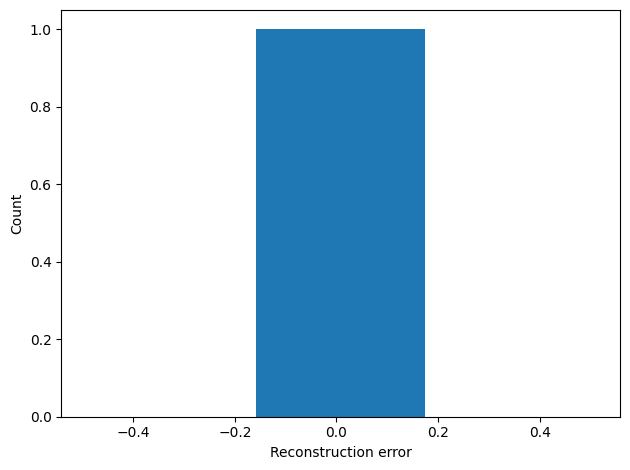

In [15]:
def reconstruction_errors(recon_errors_file, bins=50):
    """
    Plot the histogram of reconstruction errors.
    """
    errors = np.load(recon_errors_file)
    print(errors)
    fig, ax = plt.subplots(1,1)
    ax.hist(errors, bins=bins)
    ax.set_xlabel('Reconstruction error'); ax.set_ylabel('Count')
    plt.tight_layout()
    
reconstruction_errors(
    os.path.join(f'{outputs_dir}/evaluation', f'{RUN_ID}_reconstructed_errors.npy'),
    bins=3
)

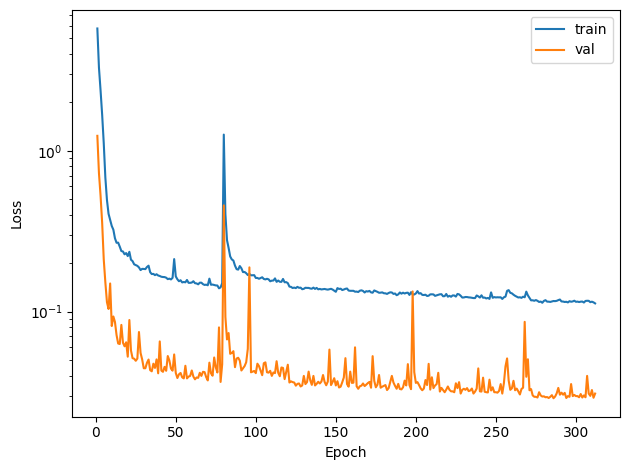

In [17]:
def plot_loss_curve(stats_file):
    """
    Plot the training and validation loss curves from a CS"V file.
    """
    df = pd.read_csv(stats_file)
    fig, ax = plt.subplots(1,1)
    ax.plot(df['epoch'], df['train_loss'], label='train')
    ax.plot(df['epoch'], df['val_loss'],   label='val')
    ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
    ax.legend()
    ax.set_yscale('log')
    plt.tight_layout()
    
plot_loss_curve(
    os.path.join(f'{stats_dir}', f'{RUN_ID}_train_autoencoder_stats.dat')
)

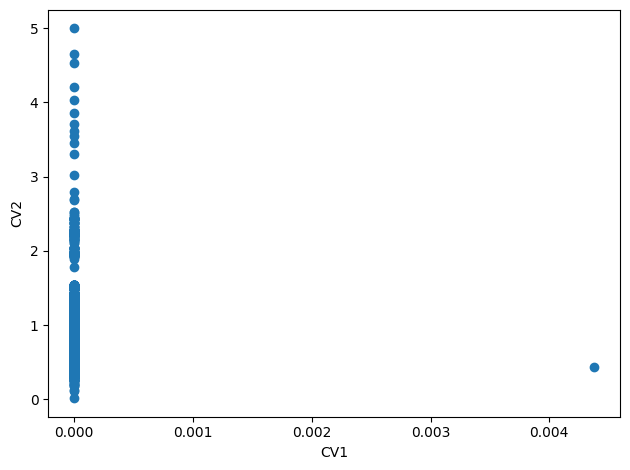

In [ ]:
def embedding_scatter(embedding_file):
    """
    Plot a scatter plot of the embeddings.
    """
    embeddings = np.load(embedding_file)
    fig, ax = plt.subplots(1,1)
    ax.scatter(embeddings[:,0], embeddings[:,1])
    ax.set_xlabel('CV1'); ax.set_ylabel('CV2')
    plt.tight_layout()

embedding_scatter(
    os.path.join(f'{outputs_dir}/evaluation', f'{RUN_ID}_embeddings.npy')
)

## Export PyTorch Model to ONNX and Visualize with Netron

This section demonstrates how to export your trained PyTorch model to the ONNX format and visualize its architecture using Netron.



**Steps:**

1. Load your model class and weights.

2. Create a dummy input tensor matching your model's input shape.

3. Export the model to ONNX.

4. Visualize the ONNX file with Netron.



> **Note:** You must have the model class definition available in the notebook. If it's in another file, import it accordingly. Adjust the dummy input shape if your model expects a different input.

In [ ]:
# Visualize with Netron
# Can be installed via pip: pip install netron
# or conda: conda install -c conda-forge netron
import netron

onnx_path = f"{models_dir}/best_autoencoder_model.onnx"
netron.start(onnx_path)
# This will open a browser window with the model visualization.